In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/converted.zip" "converted.zip"

In [ ]:
!unzip -q converted.zip

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('converted/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # 
batch_size_test = 100 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('converted/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('converted/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: TUM


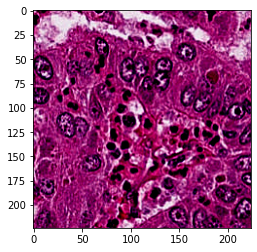

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Inceptionblock(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool):
        super().__init__()

        # convolution: 1x1 
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1  -> convolution: 3x3 
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1 -> convolution: 5x5
        # Two 3x3 stacked convolution filters used
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        # pooling: 3x3 -> convolution: 1x1
        
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool, kernel_size=1),
            nn.BatchNorm2d(pool),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=9):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        
        self.a3 = Inceptionblock(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inceptionblock(256, 128, 128, 192, 32, 96, 64)

        # The Inception network consists of inception modules stacked upon each other, with occasional max-pooling layers
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inceptionblock(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inceptionblock(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inceptionblock(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inceptionblock(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inceptionblock(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inceptionblock(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inceptionblock(832, 384, 192, 384, 48, 128, 128)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GoogleNet().to(device)
learning_rate = 0.0002
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(parameters, lr=learning_rate, weight_decay=weight_decay)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
       
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch+1)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("GoogleNet9categoriesmodel.pth"):
        os.remove("GoogleNet9categoriesmodel.pth")

      torch.save(model.state_dict(), 'GoogleNet9categoriesmodel.pth')
      acc=acct
    train_loss.append(tl)
    test_loss.append(stl)
    accuracy_test.append(acct)

!cp GoogleNet9categoriesmodel.pth '/content/drive/My Drive/Histopathology data/'

2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.8328

Test: Average loss: 0.4697, Accuracy: 4573/5400 (84.69%)

3


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.4871

Test: Average loss: 0.5748, Accuracy: 4353/5400 (80.61%)

4


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3886

Test: Average loss: 1.7883, Accuracy: 3450/5400 (63.89%)

5


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.3240

Test: Average loss: 0.1939, Accuracy: 5078/5400 (94.04%)

6


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2894

Test: Average loss: 0.1963, Accuracy: 5078/5400 (94.04%)

7


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2568

Test: Average loss: 0.1910, Accuracy: 5104/5400 (94.52%)

8


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2303

Test: Average loss: 0.1795, Accuracy: 5097/5400 (94.39%)

9


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2174

Test: Average loss: 0.6608, Accuracy: 4684/5400 (86.74%)

10


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.2019

Test: Average loss: 0.1236, Accuracy: 5192/5400 (96.15%)

11


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1883

Test: Average loss: 0.1796, Accuracy: 5095/5400 (94.35%)

12


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1830

Test: Average loss: 0.1647, Accuracy: 5112/5400 (94.67%)

13


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1641

Test: Average loss: 0.1540, Accuracy: 5153/5400 (95.43%)

14


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1680

Test: Average loss: 0.1972, Accuracy: 5062/5400 (93.74%)

15


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1467

Test: Average loss: 0.0764, Accuracy: 5283/5400 (97.83%)

16


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1485

Test: Average loss: 0.0912, Accuracy: 5269/5400 (97.57%)

17


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1392

Test: Average loss: 0.1137, Accuracy: 5211/5400 (96.50%)

18


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1423

Test: Average loss: 0.1393, Accuracy: 5177/5400 (95.87%)

19


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1365

Test: Average loss: 0.1890, Accuracy: 5065/5400 (93.80%)

20


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1292

Test: Average loss: 0.1091, Accuracy: 5229/5400 (96.83%)

21


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1169

Test: Average loss: 0.1141, Accuracy: 5196/5400 (96.22%)

22


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1218

Test: Average loss: 0.1401, Accuracy: 5177/5400 (95.87%)

23


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1144

Test: Average loss: 0.1264, Accuracy: 5174/5400 (95.81%)

24


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1101

Test: Average loss: 0.1166, Accuracy: 5200/5400 (96.30%)

25


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1085

Test: Average loss: 0.0682, Accuracy: 5298/5400 (98.11%)

26


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1091

Test: Average loss: 0.1576, Accuracy: 5131/5400 (95.02%)

27


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0967

Test: Average loss: 0.0766, Accuracy: 5271/5400 (97.61%)

28


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0970

Test: Average loss: 0.0914, Accuracy: 5251/5400 (97.24%)

29


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0993

Test: Average loss: 0.0871, Accuracy: 5244/5400 (97.11%)

30


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.1038

Test: Average loss: 0.1266, Accuracy: 5173/5400 (95.80%)

31


  0%|          | 0/1260 [00:00<?, ?it/s]

Train: Average loss: 0.0971

Test: Average loss: 0.0701, Accuracy: 5292/5400 (98.00%)



In [ ]:
train_l=str(train_loss)
test_l=str(test_loss)
accuracy_t=str(accuracy_test)

output_file = open('training_accuracy.txt', 'w')

for t in train_l:
    output_file.write(t)

output_file.close()


output_file = open('test_loss.txt', 'w')

for t in test_l:
    output_file.write(t)

output_file.close()

output_file = open('accuracy_test.txt', 'w')

for t in accuracy_t:
    output_file.write(t)

output_file.close()


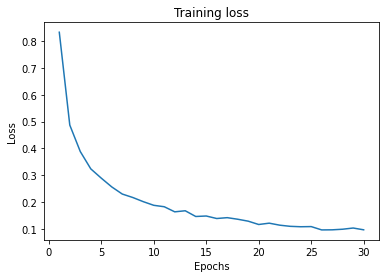

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,train_loss)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

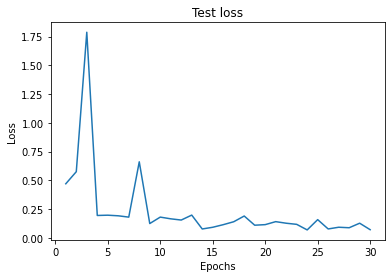

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,test_loss)
plt.title('Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

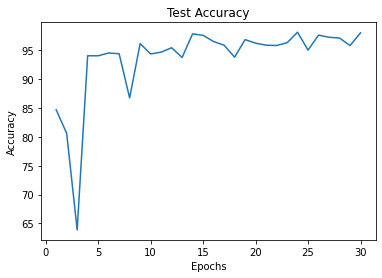

In [ ]:
X=[i+1 for i in range(30)]
plt.plot(X,accuracy_test)
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()